In [1]:
! pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.5 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

In [2]:
import medmnist
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt

First of all, we need to load the data and preprocess it. TissueMNIST has all the necessary splits: train, val, test. Also, we will use the ImageNet statistics for normalization.

In [3]:

data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # from ImageNet
])

train_dataset = medmnist.TissueMNIST(split='train', transform=data_transform, size=28, download=True)
test_dataset = medmnist.TissueMNIST(split='test', transform=data_transform, size=28, download=True)
val_dataset = medmnist.TissueMNIST(split='val', transform=data_transform, size=28, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

100%|██████████| 125M/125M [00:07<00:00, 15.9MB/s]


In [4]:
print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')

images, labels = next(iter(train_loader))
print(f'Batch shape: {images.shape}')
print(f'Labels shape: {labels.shape}')

Train dataset size: 165466
Test dataset size: 47280
Validation dataset size: 23640
Batch shape: torch.Size([32, 3, 32, 32])
Labels shape: torch.Size([32, 1])


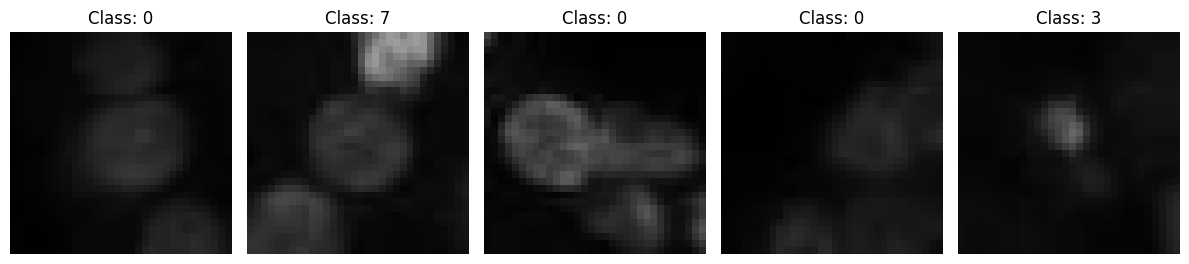

In [5]:
def denormalize_image(image):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return image * std + mean

plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = denormalize_image(images[i])
    img = img.permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(f'Class: {labels[i].item()}')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Baseline Model

In [ ]:
def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.squeeze().to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.squeeze().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)


Let's load the pre-trained ResNet-18 model and replace the final fully connected layer with a new one for our task. TissueMNIST has 8 classes, so we need to change the last layer to have 8 output neurons.

In [ ]:
def get_resnet18(num_classes=8):
    model = models.resnet18(pretrained=True)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()  # Remove aggressive downsampling
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

Let's define the loss function and optimizer. We will use the Adam optimizer with a learning rate of 0.001, since it has a good balance between convergence speed and stability. For the loss function, we will use the cross-entropy loss, since it is a good loss function for classification tasks.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 8

model = get_resnet18(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
train_optimizer = optim.Adam(model.parameters(), lr=1e-3)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


In [ ]:
epochs = 5
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, train_optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}: Train acc: {train_acc:.4f}, Val acc: {val_acc:.4f}")

Epoch 1: Train acc: 0.5931, Val acc: 0.6342
Epoch 2: Train acc: 0.6563, Val acc: 0.6610
Epoch 3: Train acc: 0.6873, Val acc: 0.6724
Epoch 4: Train acc: 0.7160, Val acc: 0.6873
Epoch 5: Train acc: 0.7487, Val acc: 0.6852


In [ ]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.6883


Now, lets also compute AUC.

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

def compute_auc_score_safe(y_probs, y_true, all_classes):
    present_classes = np.unique(y_true)

    if len(present_classes) < 2:
        print("Not enough classes in test labels to compute AUC.")
        return np.nan

    y_true_bin = label_binarize(y_true, classes=all_classes)
    probs_filtered = y_probs[:, present_classes]

    try:
        auc = roc_auc_score(y_true_bin[:, present_classes], probs_filtered, average='macro', multi_class='ovr')
        return auc
    except Exception as e:
        print(f"Error computing AUC: {e}")
        return np.nan

def get_predictions_and_labels(model, loader, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.squeeze().cpu().numpy())

    return np.array(all_probs), np.array(all_labels)

In [ ]:
y_probs, y_true = get_predictions_and_labels(model, test_loader, device)
all_classes = list(range(num_classes))

auc_score = compute_auc_score_safe(y_probs, y_true, all_classes)
print(f"Test AUC: {auc_score:.4f}")


Test AUC: 0.9339


### Target Model

In [6]:
! pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.


In [7]:
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
from tqdm import tqdm
from datasets import load_dataset
from evaluate import load
import torch
import numpy as np

Lets load the data using hugging face load_dataset function for better compatability.

In [8]:
tissueMNIST_dataset = load_dataset("albertvillanova/medmnist-v2", "tissuemnist")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.14k [00:00<?, ?B/s]

medmnist-v2.py:   0%|          | 0.00/21.6k [00:00<?, ?B/s]

The repository for albertvillanova/medmnist-v2 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/albertvillanova/medmnist-v2.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


tissuemnist.npz:   0%|          | 0.00/125M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Lets use pretrained Google vit-base-patch16-224 model architecture. Then lets train it on our dataset using the idea from here https://huggingface.co/blog/fine-tune-vit

In [9]:
model_name = "google/vit-base-patch16-224"

processor = ViTImageProcessor.from_pretrained(model_name)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [10]:
def transform(i):
  inputs = processor([img.convert("RGB") for img in i["image"]], return_tensors="pt")
  inputs["labels"] = i["label"]
  return inputs

tissueMNIST_loader = tissueMNIST_dataset.with_transform(transform)

In [11]:
train_subset = tissueMNIST_loader["train"].select(range(5000))
valid_subset = tissueMNIST_loader["validation"].select(range(1000))


In [12]:
metric = load("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [13]:
labels = tissueMNIST_loader["train"].features["label"].names

In [22]:
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(tissueMNIST_loader["train"].features["label"].names),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True,
)

training_args = TrainingArguments(
  output_dir="./output",
  per_device_train_batch_size=32,
  evaluation_strategy="steps",
  num_train_epochs=10,
  fp16=True,
  save_steps=500,
  eval_steps=500,
  logging_steps=100,
  learning_rate=2e-4,
  save_total_limit=5,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=tissueMNIST_loader["train"],
    eval_dataset=tissueMNIST_loader["validation"],

    tokenizer=processor,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-22-a413cb4a511b>:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Now, lets train the model.

In [23]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
500,1.185200,1.219501,0.535321
1000,1.120500,1.066301,0.611252
1500,1.083000,1.059710,0.605118
2000,1.021800,1.044619,0.614255
2500,1.019500,1.048339,0.605880
3000,0.995900,0.998345,0.633503
3500,0.936300,0.958713,0.653384
4000,0.947900,0.938009,0.657487
4500,0.920900,0.925645,0.657022
5000,0.941400,0.901430,0.668443


KeyboardInterrupt: 

In [25]:
from sklearn.metrics import roc_auc_score
from scipy.special import softmax
import numpy as np


preds = trainer.predict(tissueMNIST_loader["test"])


logits = preds.predictions
true_labels = preds.label_ids

probs = softmax(logits, axis=1)


auc = roc_auc_score(true_labels, probs, multi_class='ovr')

print(f"TissueMNIST AUC Score (macro-average): {auc:.4f}")


Step,Training Loss,Validation Loss,Accuracy
500,1.185200,1.219501,0.535321
1000,1.120500,1.066301,0.611252
1500,1.083000,1.059710,0.605118
2000,1.021800,1.044619,0.614255
2500,1.019500,1.048339,0.605880
3000,0.995900,0.998345,0.633503
3500,0.936300,0.958713,0.653384
4000,0.947900,0.938009,0.657487
4500,0.920900,0.925645,0.657022
5000,0.941400,0.901430,0.668443


TissueMNIST AUC Score (macro-average): 0.9305
